In [91]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import pathlib
import numpy as np

In [92]:
data_path = pathlib.Path('data')
commands = np.array(tf.io.gfile.listdir(data_path))
commands = commands[commands!='README.md']

print(commands)


['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [93]:
train_data, test_data = tf.keras.utils.audio_dataset_from_directory(
    directory = data_path,
    validation_split = 0.2,
    output_sequence_length = 16000,
    seed = 0,
    batch_size = 64,
    subset = 'both'
)

label_names= np.array(train_data.class_names)
print(label_names)

Found 7705 files belonging to 8 classes.
Using 6164 files for training.
Using 1541 files for validation.
['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [94]:
def squeeze(audio,labels):
    audio  = tf.squeeze(audio,axis=-1)
    return audio,labels

train_data = train_data.map(squeeze, tf.data.AUTOTUNE)
test_data = test_data.map(squeeze,tf.data.AUTOTUNE)



In [95]:
testing = test_data.shard(num_shards=2,index=0)
validating = test_data.shard(num_shards=2, index= 1)

In [96]:
def spectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255,frame_step=128
    )

    spectogram = tf.abs(spectogram)
    spectogram = spectogram[..., tf.newaxis]

    return spectogram


In [97]:
def make_dataset(data):
    return data.map(
        map_func = lambda audio,label :(spectogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

In [98]:
training = make_dataset(train_data)
testing = make_dataset(testing)
validating = make_dataset(validating)

In [99]:
training = training.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
testing = testing.cache().prefetch(tf.data.AUTOTUNE)
validating = validating.cache().prefetch(tf.data.AUTOTUNE)

In [100]:
for example_spectogram, example_labels in training.take(1):
    break

input_shape = example_spectogram.shape[1:]

In [101]:
num_labels = len(label_names)
print(num_labels)

8


In [102]:
norm_layers = layers.Normalization()
norm_layers.adapt(data = training.map(map_func =lambda spec, labels :spec))

In [103]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    norm_layers,
    layers.Conv2D(32,3, activation='relu'),
    layers.Conv2D(64,3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

In [104]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_4 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [105]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [106]:
history = model.fit(
    training,
    validation_data = validating,
    epochs = 10,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2612 - loss: 1.9474 - val_accuracy: 0.5703 - val_loss: 1.3567
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5310 - loss: 1.3211 - val_accuracy: 0.6745 - val_loss: 0.9753
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6426 - loss: 1.0102 - val_accuracy: 0.7357 - val_loss: 0.8102
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7022 - loss: 0.8235 - val_accuracy: 0.7643 - val_loss: 0.6805
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7587 - loss: 0.6699 - val_accuracy: 0.7865 - val_loss: 0.6208
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7922 - loss: 0.5949 - val_accuracy: 0.8125 - val_loss: 0.5904
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8164 - loss: 0.5271 - val_accuracy: 0.8372 - val_loss: 0.5331
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8266 - loss: 0.4847 - val_accuracy: 0.8229 - v

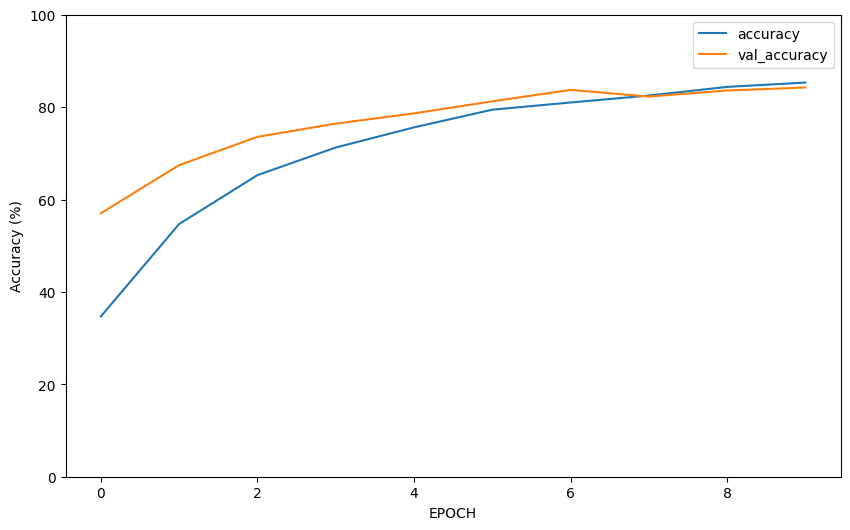

In [107]:
metrics = history.history
plt.figure(figsize=(10,6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy','val_accuracy'])
plt.ylim(0,100)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy (%)')
plt.show()

In [108]:
testing_results = model.evaluate(testing,return_dict=True)
testing_results = testing_results['accuracy']

print("Testing Accuracy: ",testing_results*100)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8213 - loss: 0.5616
Testing Accuracy:  80.98317980766296


In [109]:
counter = 0

for i, (spectogram,labels) in enumerate(testing):
    pred = model.predict(spectogram)
    pred_labels_idx = tf.argmax(pred,axis=1).numpy()
    original_label = label_names[labels.numpy()]
    pred_label = [label_names[idx] for idx in pred_labels_idx]

    for j, label in enumerate(original_label):
        print(f"{label}: {pred_label[j]}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
right: right
down: down
right: right
left: left
no: no
right: right
left: left
up: up
right: right
no: no
right: right
no: no
left: left
no: no
up: up
right: right
no: no
stop: stop
go: go
no: no
stop: stop
yes: yes
go: go
right: right
go: go
stop: stop
no: no
no: no
go: no
right: up
no: no
left: left
go: down
no: no
go: go
right: right
go: go
no: no
up: up
go: go
right: right
stop: stop
right: right
left: stop
yes: no
left: left
right: right
right: right
go: go
left: left
up: up
right: right
no: go
right: right
up: up
go: down
go: go
no: no
left: left
up: stop
right: right
stop: stop
down: down
no: no
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
right: right
up: up
down: stop
up: right
left: left
no: no
left: left
go: go
up: up
up: up
stop: down
go: go
left: left
left: left
go: go
no: go
right: right
yes: yes
go: go
up: up
down: down
right: right
yes: yes
right: left
left: left
yes: yes
no: no
up: up
go: go
up: left
no: no
no: no
up: up
up: up
left: left